In [2]:
import numpy as np  
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry

In [3]:
path=os.getcwd()+'/bias'
fitsfile=fits.open(path+'/'+'16-23-54_Ha_Bias_0.00s_0000.fits')
datax = fitsfile[0].data

In [4]:
def bias():
    path=os.getcwd()+'/bias'
    Num_of_files=len(os.listdir(path))
    Grid=np.zeros(datax.shape)
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid+=dati
    Grid/=Num_of_files
    return Grid

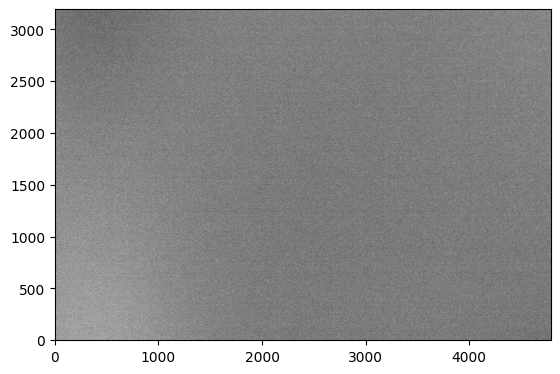

In [5]:
masterbias=bias()
mean=np.mean(masterbias)
std=np.std(masterbias)
plt.imshow(masterbias, cmap='gray', vmin=mean-2*std, vmax=mean+2*std, origin='lower')

In [6]:
pathf=os.getcwd()+'/FLATR'
fitsfilef=fits.open(pathf+'/'+'2025-10-02_09-25-17_FLAT_R__0000.fits')
dataf = fitsfilef[0].data

In [7]:
def flat(filter):
    path=os.getcwd()+'/FLAT'+filter
    Num_of_files=len(os.listdir(path))
    Grid=np.zeros((dataf.shape[0],dataf.shape[1],Num_of_files))
    j=0
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid[:,:,j]=dati
        j+=1
    master=np.median(Grid, axis=2)-masterbias
    return master/np.median(master)

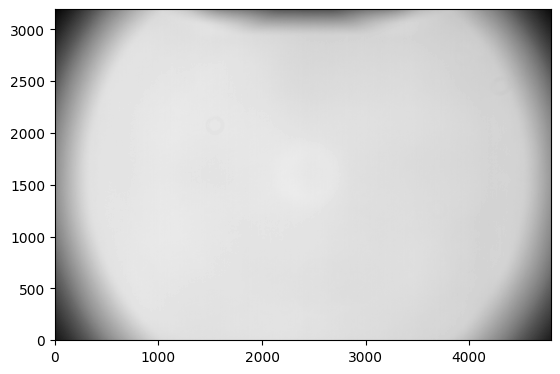

In [8]:
masterflat=flat('R')
plt.imshow(masterflat, cmap='gray', origin='lower')

In [9]:
pathd=os.getcwd()+'/DARK300'
fitsfiled=fits.open(pathd+'/'+'2025-09-25_17-59-33_DARK_300.00s_0000.fits')

datad = fitsfiled[0].data

In [10]:
def dark(time):
    path=os.getcwd()+'/DARK'+time
    Num_of_files=len(os.listdir(path))
    Grid=np.zeros((datad.shape[0],datad.shape[1],Num_of_files))
    j=0
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid[:,:,j]=dati
        j+=1
    master=np.median(Grid, axis=2)-masterbias
    return master

In [11]:
mastercurrent=dark('300')

In [12]:
fitsfiled=fits.open('2025-10-10_18-16-27_sci_M103_R_300.00s_0000.fits')
data = fitsfiled[0].data
wcs = WCS(fitsfiled[0].header)


Set MJD-AVG to 60958.763168 from DATE-AVG'. [astropy.wcs.wcs]


In [13]:
science= (data-masterbias-mastercurrent)/masterflat
mean=np.mean(science)
std=np.std(science)

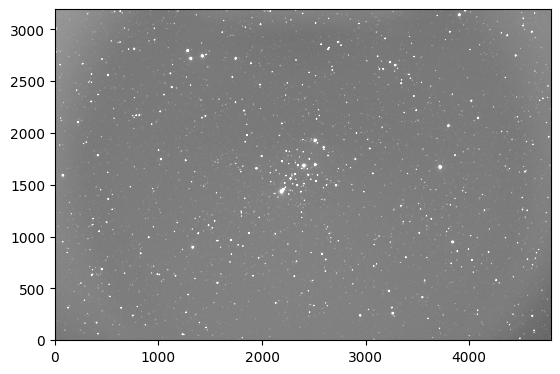

In [14]:
plt.imshow(science, vmin=mean-2*std, vmax=mean+2*std,cmap='gray',origin='lower')
pixpos = wcs.wcs_world2pix(  40.6708, 54.3489, 1)  # RA, DEC in degrees

In [15]:
print(pixpos)

[array(21842.27292248), array(72781.75851408)]


In [16]:
GAIAspectrum = fits.open('GAIA3_509862066010920960.fits')

In [17]:
r_trasm = Table.read('r_trasmission.txt', format='ascii.basic')
r_wave=r_trasm["Wavelength(A)"]
r_value=r_trasm["Transmission(QE*Filter)"]

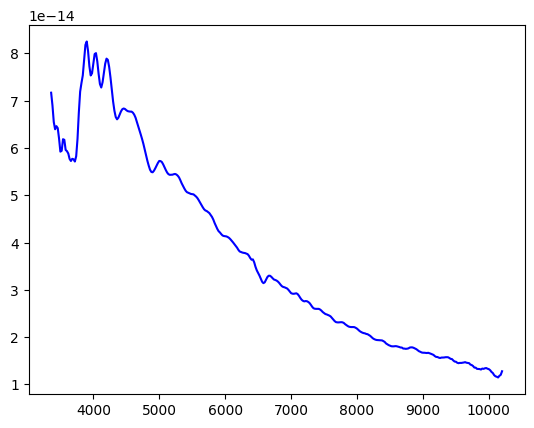

In [18]:
plt.plot(GAIAspectrum[1].data, GAIAspectrum[0].data, color='blue')

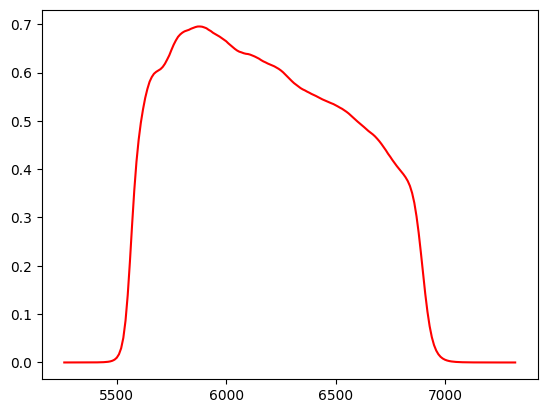

In [19]:
plt.plot(r_wave, r_value,color='red')

New y of the filter 

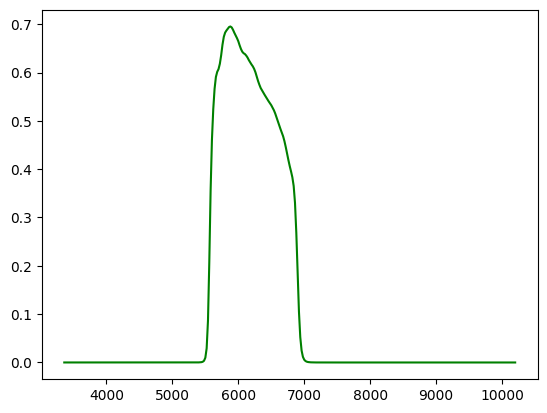

In [20]:
r_trasm_new=np.interp(GAIAspectrum[1].data, r_wave, r_value)
plt.plot(GAIAspectrum[1].data, r_trasm_new,color='green')

In [21]:
x=GAIAspectrum[1].data
y_filter=r_trasm_new
y_spectrum=np.array(GAIAspectrum[0].data)


In [22]:
Num = np.trapz(y_spectrum * y_filter, x)
Den= np.trapz(y_filter, x)
F=Num/Den           # Factor for the flux
F

3.927128091939314e-14

In [23]:
pixpos = wcs.wcs_world2pix(23.38804096055661,60.63702187961969, 1)  # RA, DEC in degrees
pixpos      #pixel position of our star

[array(2450.43582191), array(1749.18995918)]

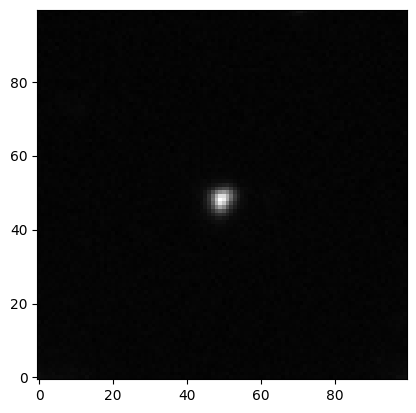

In [24]:
science_e=science*0.25/300         
sci_cut = science_e[1700:1800,2400:2500]
plt.imshow(sci_cut,cmap='gray',origin='lower') #it resclaes the pixel 

In [25]:
position = pixpos[0]-2400, pixpos[1]-1700  # (x, y) position of the star in the cutout
Apertures = [CircularAperture(position, r=i) for i in np.arange(1, 30, 0.5)]

In [26]:
fluxs=aperture_photometry(sci_cut,Apertures)
# for col in fluxs.colnames:
#     fluxs[col].info.format = '%.8g'  # for consistent table output
fluxs

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14,aperture_sum_15,aperture_sum_16,aperture_sum_17,aperture_sum_18,aperture_sum_19,aperture_sum_20,aperture_sum_21,aperture_sum_22,aperture_sum_23,aperture_sum_24,aperture_sum_25,aperture_sum_26,aperture_sum_27,aperture_sum_28,aperture_sum_29,aperture_sum_30,aperture_sum_31,aperture_sum_32,aperture_sum_33,aperture_sum_34,aperture_sum_35,aperture_sum_36,aperture_sum_37,aperture_sum_38,aperture_sum_39,aperture_sum_40,aperture_sum_41,aperture_sum_42,aperture_sum_43,aperture_sum_44,aperture_sum_45,aperture_sum_46,aperture_sum_47,aperture_sum_48,aperture_sum_49,aperture_sum_50,aperture_sum_51,aperture_sum_52,aperture_sum_53,aperture_sum_54,aperture_sum_55,aperture_sum_56,aperture_sum_57
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,50.43582191493215,49.18995917828329,73.17688588300365,159.0184486646687,269.1691821975233,396.26145855076453,536.8893495095513,683.7080716220675,838.425025991399,996.5819951222943,1162.6293158920105,1335.3341501444295,1518.2265327382931,1710.8138992074314,1915.2430454000673,2131.7167961008495,2361.631048839625,2604.9632873203655,2862.102504699288,3132.9591932254148,3417.66639198533,3716.3771089823376,4029.76725128041,4357.813758484176,4700.385559654624,5056.7765218198,5427.040846877238,5812.19516570833,6212.06040937199,6625.832762658264,7053.63990189853,7495.9062153448485,7952.447913191987,8422.983561772355,8908.066768197315,9408.215392296846,9922.90316876365,10451.869705022233,10995.67333861046,11553.957928779391,12126.716383620105,12713.58248180517,13314.619790293158,13930.073053167998,14559.878846673866,15204.68500009436,15863.75945007593,16537.368873584695,17226.067795831303,17928.1970024807,18644.49872330774,19375.103452477866,20119.80096396154,20879.52160299725,21654.30059641487,22442.869257746035,23245.225456989,24062.255679900634,24893.930124398827,25740.03665954731


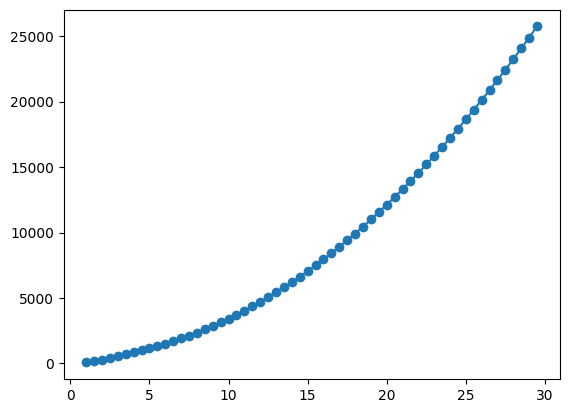

In [27]:
flux=fluxs[0][3:]
plt.plot(np.arange(1,30,0.5), flux, marker='o') #without background subtraction it increase as r^2

In [28]:
# now we substract the background

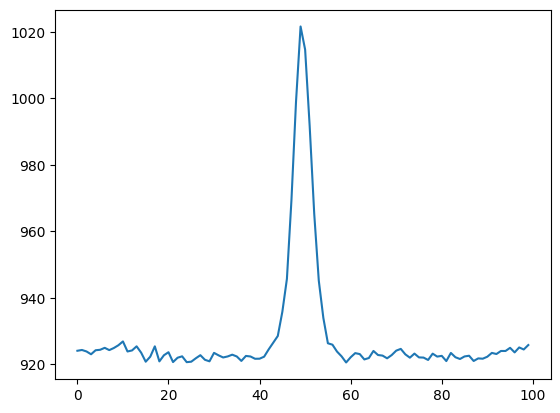

In [29]:
star=np.sum(sci_cut, axis=0)
plt.plot(star)

In [30]:
ri=20
rext=30
#where there the plot is flat 

In [31]:
annulus_aperture = CircularAnnulus(position, r_in=ri, r_out=rext)

In [ ]:
from photutils.aperture import ApertureStats
aper_stats = ApertureStats(sci_cut, annulus_aperture)            #all the statistics
bkg_mean = aper_stats.mean
print(bkg_mean)

apertures_area = [A.area for A in Apertures]

9.213903262808001


In [33]:
bkg_total=bkg_mean*np.array(apertures_area)
#bkg_total

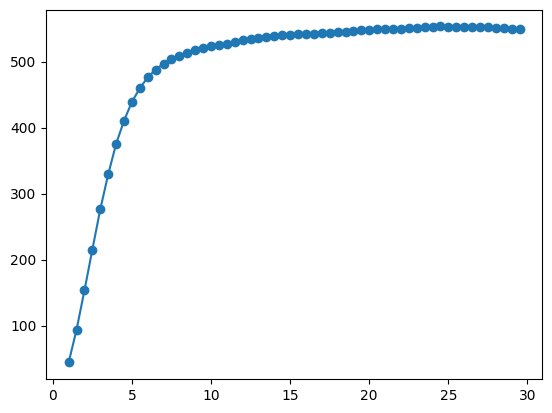

In [34]:
phot_final=flux - bkg_total
plt.plot(np.arange(1,30,0.5), phot_final, marker='o')  #now it flattens at large r

In [35]:
r=15
ap=CircularAperture(position, r=15)
photo_inside=aperture_photometry(sci_cut,ap)
final_flux=photo_inside[0][3:]

an_ap=CircularAnnulus(position, r_in=ri, r_out=rext)
aperstats= ApertureStats(sci_cut, an_ap)
bkg_mean=aperstats.mean

aperture_area=ap.area
totoal_bkg=bkg_mean*aperture_area
final_flux_bkgsubtracted=final_flux - totoal_bkg

In [36]:
F/final_flux_bkgsubtracted  #magnitude calculation

array([7.26283655e-17])

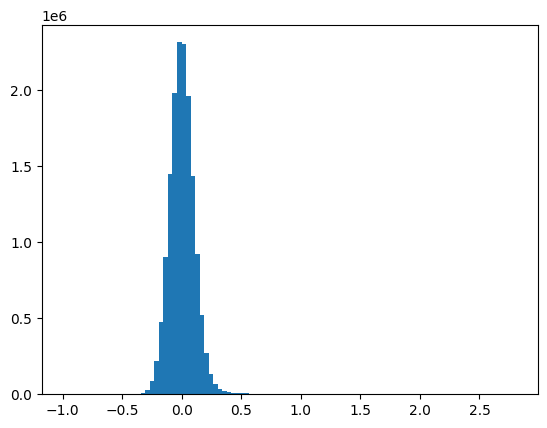

In [37]:
a, b, c= plt.hist(science_e.flatten()[(science_e.flatten()>8) & (science_e.flatten()<12)]-np.median(science_e.flatten()[(science_e.flatten()>8) & (science_e.flatten()<10)]), bins=100)

In [38]:
import sep

data=science_e-np.median(science_e)
std=np.std(science_e)
objects, map = sep.extract(data, 2, err=std, segmentation_map=True)              #return an image 
len(objects)

927

In [39]:
bkg = sep.Background(data, mask=map, bw=64, bh=64, fw=12, fh=12)

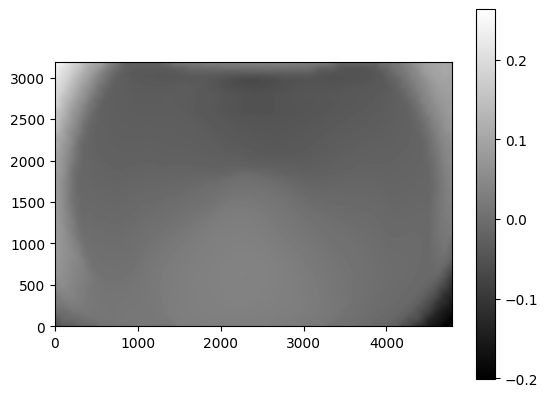

In [40]:
plt.imshow(bkg, cmap='gray', origin='lower')
plt.colorbar()

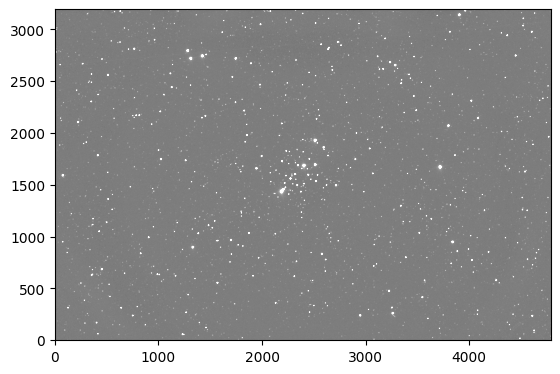

In [48]:
Final=science_e-bkg
mean_f=np.mean(Final)
std_f=np.std(Final)
plt.imshow(Final, vmin=mean_f-2*std_f,vmax=mean_f+2*std_f,cmap='gray', origin='lower')

In [90]:
from reproject import reproject_interp

from astropy.coordinates import SkyCoord
from astropy import units as u


# coordinates of m103

c = SkyCoord('01:33:12 +60:42:00', unit=(u.hourangle, u.deg))
c

<SkyCoord (ICRS): (ra, dec) in deg
    (23.3, 60.7)>

In [96]:
ref_wcs =  WCS(naxis=2)

#metti le coordinate di M103
ref_wcs.wcs.crval =[c.ra.degree, c.dec.degree]
ref_wcs.wcs.crpix =[3500/2.0, 3500/2.0]  
ref_wcs.wcs.ctype =["RA---TAN", "DEC--TAN"] 
ref_wcs.wcs.cunit=["deg", "deg"]


#trasformation of 0.55 arcsec/pixel

dim_degrees= (0.55/3600.0)

ref_wcs.wcs.cd= np.array([[-dim_degrees, 0.0], [0.0, dim_degrees]])

In [97]:
new_repr= reproject_interp((Final, wcs), ref_wcs, shape_out=(3500,3500))

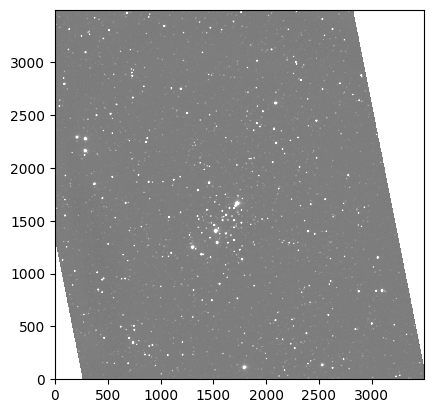

In [98]:
plt.imshow(new_repr[0], vmin=mean_f-2*std_f,vmax=mean_f+2*std_f,cmap='gray', origin='lower')